# Visualize target and prior distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


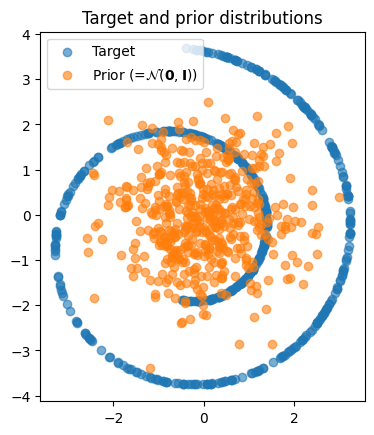

In [96]:
%load_ext autoreload
%autoreload 2

from dataset import TwoDimDataClass, get_data_iterator
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import io

target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', 'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

# Define a diffusion model

In [97]:
from network import SimpleNet
from model import DiffusionModule
from scheduler import DPMSolverScheduler

# hyperparameters #
device = "cuda:0"
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128],
    "lr": 1e-3,
    "batch_size": 128,
    "num_train_iters": 5000,
    "device": device,
    "num_inference_steps": 50,
}

###################

def build_dpm(config):
    network = SimpleNet(dim_in=2, 
                        dim_out=2, 
                        dim_hids=config["dim_hids"], 
                        num_timesteps=config["num_diffusion_steps"]
                       )
    var_scheduler = DPMSolverScheduler(config["num_diffusion_steps"])
    var_scheduler.set_timesteps(config["num_inference_steps"])

    dpm = DiffusionModule(network, var_scheduler).to(config["device"])
    # For high-order sampling
    dpm.var_scheduler.net_forward_fn = dpm.network.forward
    return dpm

dpm = build_dpm(config)

# Visualize $\psi_t(x | x_1)$

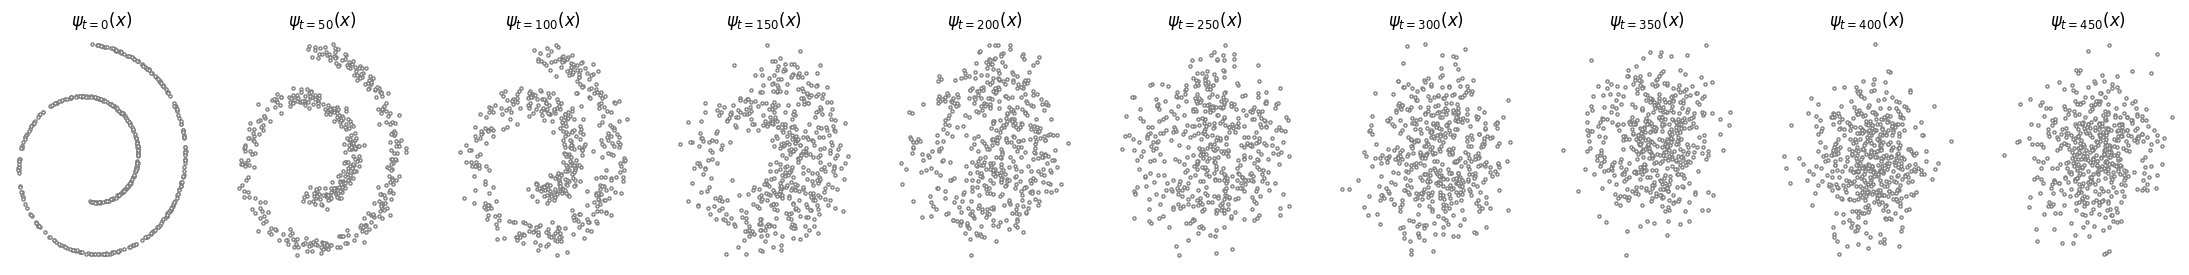

In [98]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i, t in enumerate(range(0, 500, 50)):
    x_t = dpm.q_sample(target_ds[:num_vis_particles].to(device), (torch.ones(num_vis_particles) * t).to(device))
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white',edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title('$\psi_{t='+str(t)+'}(x)$')

# Training

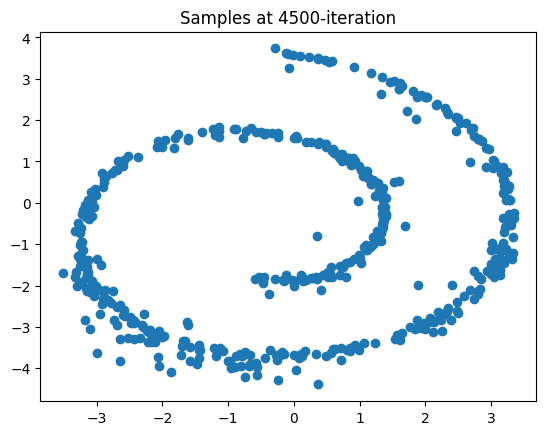

loss: 0.3537: 100%|██████████| 5000/5000 [00:54<00:00, 91.57it/s] 


interactive(children=(IntSlider(value=1, description='index', max=9), Output()), _dom_classes=('widget-interac…

Output()

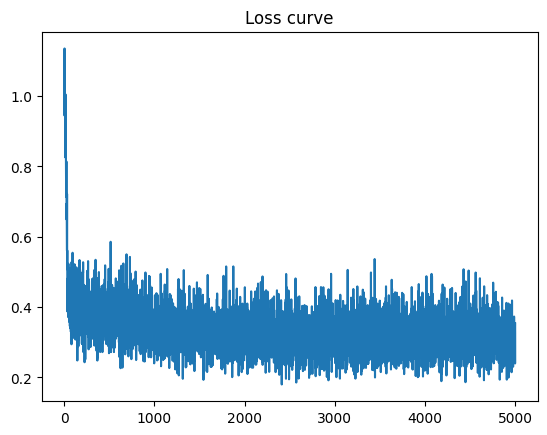

In [99]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Initialize the model.
dpm = build_dpm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(dpm.network.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()
        
        batch_x = next(train_iter)
        batch_x = batch_x.to(device)
        loss = dpm.get_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")
        
        losses.append(loss.item())
        
        if step % 500 == 0:
            with torch.no_grad():
                x0 = dpm.sample(shape=(num_vis_particles, 2)).cpu()
                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)
                
except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

# Evaluation

In [102]:
# First-order DPM-Solver
from chamferdist import chamfer_distance

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = dpm.sample(shape=(num_eval_particles, 2), num_inference_timesteps=50, order=1)

with torch.no_grad():
    cd = chamfer_distance(
        pc_gen.reshape(num_eval_particles, 2).cpu().numpy(), 
        pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
    )
    print(f"Chamfer Distance: {cd.item():.4f}")

100%|██████████| 50/50 [00:00<00:00, 648.37it/s]

Chamfer Distance: 46.5892


## Task 2 (Optional)

Task 2 is optional to get additional points to make up lost points in other assignments.

The total credits across all assignments are 130 (20*6 + 10). 

In [103]:
# Task 2 (Optional) Second-order DPM-Solver
num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = dpm.sample(shape=(num_eval_particles, 2), num_inference_timesteps=50, order=2)

with torch.no_grad():
    cd = chamfer_distance(
        pc_gen.reshape(num_eval_particles, 2).cpu().numpy(), 
        pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
    )
    print(f"Chamfer Distance: {cd.item():.4f}")

100%|██████████| 25/25 [00:00<00:00, 286.05it/s]

Chamfer Distance: 39.6730
